<a href="https://colab.research.google.com/github/Ripa-Shah/Analyzing-Social-Sentiment-Data-to-determine-correlation-with-Cryptocurrency-Price/blob/main/MIS584_Cryptocurrency_sentimentdata_and_prices_11_18_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark praw nltk pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 6.0 MB/s eta 0:00:00


In [2]:
%pwd

'/content'

In [3]:
pip install tweepy praw requests pandas textblob vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.9 MB/s eta 0:00:00


In [4]:
pip install vaderSentiment

In [5]:
import praw
import pandas as pd
import time
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [9]:
from google.colab import drive
drive.mount('/content/drive')
DATA_FOLDER_PATH = '/content/drive/MyDrive/ColabNotebooks/Data'

# Example: List the contents of your data folder
import os
print(os.listdir(DATA_FOLDER_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['mis584_float.txt', 'converted_file2.txt', 'transformed_numbers.txt', 'stock_schema.avsc', 'wikidata.csv', '.ipynb_checkpoints', 'crypto_prices.csv', 'reddit_crypto_sentiment_analysis.csv']


In [10]:
%cd /content/drive/MyDrive/ColabNotebooks/Data

/content/drive/MyDrive/ColabNotebooks/Data


In [11]:
%pwd

'/content/drive/MyDrive/ColabNotebooks/Data'

In [12]:
pip install yfinance pandas

In [13]:
!pip install pyspark

In [14]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("MIS584_Spark_Basics")
sc = SparkContext(conf = conf)

In [15]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MIS584_Spark_Basics").getOrCreate()

In [16]:

# you can get a spark context from a spark session
sc = spark.sparkContext

In [ ]:
#download the dataset crypto_prices_historical.csv and reddit_crypto_Sentiment.csv

In [17]:
# create a spark dataframe from a pandas dataframe
import pandas as pd

## first, read the external csv file into a pandas dataframe
crypto_prices = pd.read_csv('crypto_prices.csv')

## then, convert the pandas dataframe to a spark dataframe
df_crypto_prices = spark.createDataFrame(crypto_prices)
df_crypto_prices.show(n=10)

## we can also convert a spark dataframe to a pandas dataframe
pdf_crypto_prices = df_crypto_prices.toPandas()
print(pdf_crypto_prices.head(20))

+-------------------+-------+-------------+
|          timestamp| symbol|        price|
+-------------------+-------+-------------+
|2024-06-15 00:00:00|BTC-USD|66211.7734375|
|2024-06-15 04:00:00|BTC-USD|66027.9296875|
|2024-06-15 08:00:00|BTC-USD|66280.4453125|
|2024-06-15 12:00:00|BTC-USD|66270.0390625|
|2024-06-15 16:00:00|BTC-USD|66120.8828125|
|2024-06-15 20:00:00|BTC-USD|   66188.1875|
|2024-06-16 00:00:00|BTC-USD|66103.5703125|
|2024-06-16 04:00:00|BTC-USD|66228.0703125|
|2024-06-16 08:00:00|BTC-USD|66442.4765625|
|2024-06-16 12:00:00|BTC-USD|  66650.28125|
+-------------------+-------+-------------+
only showing top 10 rows

              timestamp   symbol         price
0   2024-06-15 00:00:00  BTC-USD  66211.773438
1   2024-06-15 04:00:00  BTC-USD  66027.929688
2   2024-06-15 08:00:00  BTC-USD  66280.445312
3   2024-06-15 12:00:00  BTC-USD  66270.039062
4   2024-06-15 16:00:00  BTC-USD  66120.882812
5   2024-06-15 20:00:00  BTC-USD  66188.187500
6   2024-06-16 00:00:00  BTC-

In [19]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
# Import any other types you need (StringType, IntegerType, etc.)
# create a spark dataframe from a csv file with inferred schema:
# df_reddit_crypto_price = spark.read.csv('crypto_prices.csv', header=True, inferSchema=True) # Spark will automatically detect the data type of each column.
# df_reddit_crypto_price.show()

# print the schema (column names and types of a dataframe)
# print('Inferred Schema of the DataFrame:')
# df_reddit_crypto_price.printSchema()

# create a spark dataframe from a csv file with specified schema:
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('symbol', StringType(), True),
    StructField('price',DoubleType(),True)
])
df_reddit_crypto_price = spark.read.csv('crypto_prices.csv', header=True, schema=schema)
print('Specified Schema of the DataFrame:')
df_reddit_crypto_price.printSchema()

#rename column timestamp to date
df_reddit_crypto_price = df_reddit_crypto_price.withColumnRenamed("timestamp", "date")

# Display the new schema to confirm the change
df_reddit_crypto_price.printSchema()


Specified Schema of the DataFrame:
root
 |-- timestamp: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- date: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- price: double (nullable = true)



In [20]:
df_reddit_price_renamed = df_reddit_crypto_price.withColumnRenamed("timestamp", "date")

In [22]:
# create a spark dataframe from a pandas dataframe
import pandas as pd

## first, read the external csv file into a pandas dataframe
df_reddit_crypto_sentiment = pd.read_csv('reddit_crypto_sentiment_analysis.csv')

## then, convert the pandas dataframe to a spark dataframe
df_reddit_crypto_sentiment = spark.createDataFrame(pdf_crypto_prices)
df_reddit_crypto_sentiment.show(n=5)

## we can also convert a spark dataframe to a pandas dataframe
pdf_reddit_sentiment = df_reddit_crypto_sentiment.toPandas()
print(pdf_reddit_sentiment.head(20))

+-------------------+-------+-------------+
|          timestamp| symbol|        price|
+-------------------+-------+-------------+
|2024-06-15 00:00:00|BTC-USD|66211.7734375|
|2024-06-15 04:00:00|BTC-USD|66027.9296875|
|2024-06-15 08:00:00|BTC-USD|66280.4453125|
|2024-06-15 12:00:00|BTC-USD|66270.0390625|
|2024-06-15 16:00:00|BTC-USD|66120.8828125|
+-------------------+-------+-------------+
only showing top 5 rows

              timestamp   symbol         price
0   2024-06-15 00:00:00  BTC-USD  66211.773438
1   2024-06-15 04:00:00  BTC-USD  66027.929688
2   2024-06-15 08:00:00  BTC-USD  66280.445312
3   2024-06-15 12:00:00  BTC-USD  66270.039062
4   2024-06-15 16:00:00  BTC-USD  66120.882812
5   2024-06-15 20:00:00  BTC-USD  66188.187500
6   2024-06-16 00:00:00  BTC-USD  66103.570312
7   2024-06-16 04:00:00  BTC-USD  66228.070312
8   2024-06-16 08:00:00  BTC-USD  66442.476562
9   2024-06-16 12:00:00  BTC-USD  66650.281250
10  2024-06-16 16:00:00  BTC-USD  66505.476562
11  2024-06-16 

In [23]:
from pyspark.sql.types import *

# create a spark dataframe from a csv file with inferred schema:
df_reddit_crypto = spark.read.csv('reddit_crypto_sentiment_analysis.csv', header=True, inferSchema=True) # Spark will automatically detect the data type of each column.
df_reddit_crypto.show()

# print the schema (column names and types of a dataframe)
print('Inferred Schema of the DataFrame:')
df_reddit_crypto.printSchema()

# create a spark dataframe from a csv file with specified schema:
schema = StructType([
    StructField('date', TimestampType(), True),
    StructField('user_id', StringType(), True),
    StructField('tyoe', StringType(), True),
    StructField('title', StringType(), True),
    StructField('cryptocurrency', StringType(), True),
    StructField('review',StringType(),True),
    StructField('sentiment_score',DoubleType(),True)
])
df_reddit_crypto = spark.read.csv('reddit_crypto_sentiment_analysis.csv', header=True, schema=schema)
print('Specified Schema of the DataFrame:')
df_reddit_crypto.printSchema()

+--------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+
|                date|             user_id|   type|               title|cryptocurrency|              review|sentiment_score|
+--------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+
| 2025-11-17 04:00:00|          GreedVault|   post|Emails Reveal Jef...|           BTC|                NULL|            0.0|
| 2025-11-17 04:00:00|    light_death-note|comment|Emails Reveal Jef...|           BTC|Ladies and gentle...|         0.4588|
| 2025-11-17 04:00:00|  Next_Statement6145|comment|Emails Reveal Jef...|           BTC|*New bitcoin fude...|            0.0|
| 2025-11-17 04:00:00|           furezasan|comment|Emails Reveal Jef...|           BTC|Everything is com...|            0.0|
| 2025-11-17 04:00:00| Uncomfortable_Newt_|comment|Emails Reveal Jef...|           BTC|Crypto, built on ...|         0.2263|


In [24]:
# get the number of rows for a dataframe
print()
print('Number of rows of the DataFrame:', df_reddit_crypto.count())

# get the number of columns and column ames for a dataframe
print()
print('Number of columns of the DataFrame:', len(df_reddit_crypto.columns))
print('Column names of the DataFrame:', df_reddit_crypto.columns)


Number of rows of the DataFrame: 4463

Number of columns of the DataFrame: 7
Column names of the DataFrame: ['date', 'user_id', 'tyoe', 'title', 'cryptocurrency', 'review', 'sentiment_score']


In [25]:
# drop duplicates from a reddit sentiment dataframe
print('Number of rows before dropping duplicates:', df_reddit_crypto.count())
df_reddit_crypto.dropDuplicates().count()
print('Number of rows after dropping duplicates:', df_reddit_crypto.dropDuplicates().count())

Number of rows before dropping duplicates: 4463
Number of rows after dropping duplicates: 3670


In [26]:
#drop duplicates from yahoo finance prices dataset

print('Number of rows before dropping duplicates:', df_reddit_price_renamed.count())
df_yahoo_price_unique = df_reddit_price_renamed.dropDuplicates()
print('Number of rows after removing duplicates:',df_yahoo_price_unique.count())

Number of rows before dropping duplicates: 15630
Number of rows after removing duplicates: 15630


In [27]:
#print statistics of data frame

df_yahoo_price_unique.describe()

DataFrame[summary: string, date: string, symbol: string, price: string]

In [28]:
#print statistics of data frame
df_reddit_crypto.describe()



DataFrame[summary: string, user_id: string, tyoe: string, title: string, cryptocurrency: string, review: string, sentiment_score: string]

In [29]:
#rename column tyoe to type

df_reddit_crypto = df_reddit_crypto.withColumnRenamed("tyoe", "type")

# Display the new schema to confirm the change
df_reddit_crypto.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- user_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- cryptocurrency: string (nullable = true)
 |-- review: string (nullable = true)
 |-- sentiment_score: double (nullable = true)



In [30]:
from pyspark.sql.functions import current_timestamp, to_timestamp


In [31]:
#fill missing values with keyword missing and for sentiment_score ->0.0
df_reddit_crypto_filled = df_reddit_crypto.na.fill(value=0.0, subset=['sentiment_score'])
#df_reddit_crypto.na.fill(current_timestamp(), subset=["date"])
df_reddit_crypto_missing = df_reddit_crypto_filled.na.fill(value='missing', subset=['cryptocurrency','title','review','user_id','type'])
#df_reddit_crypto.na.fill(value='1/1/1930', subset=['date']).show(100)

In [32]:
df_reddit_crypto_missing.show(5)

+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+
|2025-11-17 04:00:00|         GreedVault|   post|Emails Reveal Jef...|           BTC|             missing|            0.0|
|2025-11-17 04:00:00|   light_death-note|comment|Emails Reveal Jef...|           BTC|Ladies and gentle...|         0.4588|
|2025-11-17 04:00:00| Next_Statement6145|comment|Emails Reveal Jef...|           BTC|*New bitcoin fude...|            0.0|
|2025-11-17 04:00:00|          furezasan|comment|Emails Reveal Jef...|           BTC|Everything is com...|            0.0|
|2025-11-17 04:00:00|Uncomfortable_Newt_|comment|Emails Reveal Jef...|           BTC|Crypto, built on ...|         0.2263|
+---------------

In [33]:
print("Total number of rows before removing null values from date field")
df_reddit_crypto_missing.count()
df_reddit_crypto_cleaned = df_reddit_crypto_missing.dropna(subset=['date'])
print("Total number of rows after removing null values from date field")
df_reddit_crypto_cleaned.count()

Total number of rows before removing null values from date field
Total number of rows after removing null values from date field


2771

In [34]:
from pyspark.sql.functions import col, when
# List of values to EXCLUDE
excluded_cryptos = ["BTC", "ETH", "SOL", "ADA","DOGE","missing"]  # Adjusted BTH to BTC for clarity

# Find rows where the cryptocurrency IS NOT in the excluded list
df_other_cryptos = df_reddit_crypto_cleaned.filter(~col("cryptocurrency").isin(excluded_cryptos)
)

df_reddit_main_cryptos = df_reddit_crypto_cleaned.filter(col("cryptocurrency").isin(excluded_cryptos))
print("--Main cryptos")
df_reddit_main_cryptos.show()
df_reddit_main_cryptos_count = df_reddit_main_cryptos.count()
print("--Main cryptos to count:",{df_reddit_main_cryptos_count})


# Display the result
print("--- Rows where cryptocurrency IS NOT BTC, ETH, SOL, or ADA ---")
df_other_cryptos.show()

# count the result
df_other_cryptos_count = df_other_cryptos.count()
print("Total excluded count",{df_other_cryptos_count})

# Show the distinct names of the excluded cryptocurrencies
#df_to_save = df_other_cryptos.select("cryptocurrency").distinct()

# Assuming 'df_to_save' is the DataFrame you want to export (e.g., df_other_cryptos)

#CSV_FILE_EXCLUDE= 'exclude_cryptocurrency.csv'
#df_to_save.write.csv(
 #   CSV_FILE_EXCLUDE,
 #   mode="overwrite",      # Options: 'overwrite', 'append', 'ignore', 'error' (default)
 #   header=True            # Writes the column names as the first line of the file
#)


--Main cryptos
+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+
|               date|             user_id|   type|               title|cryptocurrency|              review|sentiment_score|
+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+
|2025-11-17 04:00:00|          GreedVault|   post|Emails Reveal Jef...|           BTC|             missing|            0.0|
|2025-11-17 04:00:00|    light_death-note|comment|Emails Reveal Jef...|           BTC|Ladies and gentle...|         0.4588|
|2025-11-17 04:00:00|  Next_Statement6145|comment|Emails Reveal Jef...|           BTC|*New bitcoin fude...|            0.0|
|2025-11-17 04:00:00|           furezasan|comment|Emails Reveal Jef...|           BTC|Everything is com...|            0.0|
|2025-11-17 04:00:00| Uncomfortable_Newt_|comment|Emails Reveal Jef...|           BTC|Crypto, built on ...|         0

In [35]:

# apply the filter transformation on a dataframe
print('Reddit posts and comments positive sentiment score:')
df_reddit_main_cryptos.filter(df_reddit_crypto['sentiment_score'] > 0.0)
df_reddit_main_cryptos.show(n=5)
print('Reddit posts and comments negative sentiment score:')
df_reddit_main_cryptos.filter(df_reddit_crypto['sentiment_score'] < 0.0)
df_reddit_main_cryptos.show(n=5)
print('Reddit posts and comments neutral sentiment score:')
df_reddit_main_cryptos.filter(df_reddit_crypto['sentiment_score'] == 0.0)
df_reddit_main_cryptos.show(n=5)



Reddit posts and comments positive sentiment score:
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+
|2025-11-17 04:00:00|         GreedVault|   post|Emails Reveal Jef...|           BTC|             missing|            0.0|
|2025-11-17 04:00:00|   light_death-note|comment|Emails Reveal Jef...|           BTC|Ladies and gentle...|         0.4588|
|2025-11-17 04:00:00| Next_Statement6145|comment|Emails Reveal Jef...|           BTC|*New bitcoin fude...|            0.0|
|2025-11-17 04:00:00|          furezasan|comment|Emails Reveal Jef...|           BTC|Everything is com...|            0.0|
|2025-11-17 04:00:00|Uncomfortable_Newt_|comment|Emails Reveal Jef...|           BTC|Cr

In [36]:
#Add additional column called sentiment_label
from pyspark.sql.functions import col, when
POSITIVE_THRESHOLD = 0.1
NEGATIVE_THRESHOLD = -0.1

df_reddit_main_cryptos = df_reddit_main_cryptos.withColumn(
    "sentiment_label",
    when(col("sentiment_score") > POSITIVE_THRESHOLD, "Positive")
    .when(col("sentiment_score") < NEGATIVE_THRESHOLD, "Negative")
    .otherwise("Neutral")
)
df_reddit_main_cryptos.show(n=10)


+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+---------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_label|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+---------------+
|2025-11-17 04:00:00|         GreedVault|   post|Emails Reveal Jef...|           BTC|             missing|            0.0|        Neutral|
|2025-11-17 04:00:00|   light_death-note|comment|Emails Reveal Jef...|           BTC|Ladies and gentle...|         0.4588|       Positive|
|2025-11-17 04:00:00| Next_Statement6145|comment|Emails Reveal Jef...|           BTC|*New bitcoin fude...|            0.0|        Neutral|
|2025-11-17 04:00:00|          furezasan|comment|Emails Reveal Jef...|           BTC|Everything is com...|            0.0|        Neutral|
|2025-11-17 04:00:00|Uncomf

In [37]:
# group a dataframe by certain columns and calculate group statistics
from pyspark.sql.functions import max, min, sum, avg, stddev, round, count

print('Top total number of posts and comments posted by a userid:')
df_reddit_count = df_reddit_main_cryptos.groupby('user_id').agg(
    count('review').alias('total_reviews'),
    count('title').alias('total_titles')
)
df_reddit_count_sort = df_reddit_count.sort(col('total_reviews').desc(), col('total_titles').desc())
df_reddit_count_sort.show(n=10)

Top total number of posts and comments posted by a userid:
+------------------+-------------+------------+
|           user_id|total_reviews|total_titles|
+------------------+-------------+------------+
|     coinfeeds-bot|           89|          89|
|       DryMyBottom|           45|          45|
|         kirtash93|           42|          42|
|          partymsl|           40|          40|
|         Anonymous|           32|          32|
|Next_Statement6145|           28|          28|
|     AutoModerator|           27|          27|
|    CriticalCobraz|           23|          23|
|             KIG45|           23|          23|
|Silver-Maximum9190|           22|          22|
+------------------+-------------+------------+
only showing top 10 rows



In [38]:
# Total number of unique user who have posted comments and post for cryptocurrency
from pyspark.sql.functions import col, countDistinct
df_reddit_crypto_count =  df_reddit_main_cryptos.groupBy("cryptocurrency", "type").agg(
    countDistinct("user_id").alias("unique_user_count")
)

df_reddit_crypto_count.select(['unique_user_count', 'cryptocurrency', 'type'])\
.sort('unique_user_count', 'cryptocurrency', ascending=[False, False]).show(n=15)

+-----------------+--------------+-------+
|unique_user_count|cryptocurrency|   type|
+-----------------+--------------+-------+
|             1286|           BTC|comment|
|              405|           ETH|comment|
|              103|           SOL|comment|
|               70|           BTC|   post|
|               41|           ADA|comment|
|               37|           ETH|   post|
|               11|           SOL|   post|
|                8|          DOGE|comment|
|                5|           ADA|   post|
|                1|          DOGE|   post|
+-----------------+--------------+-------+



In [39]:
print("Before removing date field's null values")
print(df_reddit_main_cryptos.count())
print("After removing date field's null values")
df_reddit_drop_rows = df_reddit_main_cryptos.dropna(subset=['date'])
print(df_reddit_drop_rows.count())
# 1. Fill with a constant date (e.g., '1900-01-01')
default_date = "1900-01-01 00:00:00"
#df_reddit_crypto_filled_date = df_reddit_main_cryptos['date'].fillna(default_date)
df_reddit_crypto_filled_date = df_reddit_main_cryptos.fillna(
    # Pass a dictionary: {'column_name': fill_value}
    value={'date': default_date}
)
print("After filling constant date")
df_reddit_crypto_filled_date.show(10)

Before removing date field's null values
2749
After removing date field's null values
2749
After filling constant date
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+---------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_label|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+---------------+
|2025-11-17 04:00:00|         GreedVault|   post|Emails Reveal Jef...|           BTC|             missing|            0.0|        Neutral|
|2025-11-17 04:00:00|   light_death-note|comment|Emails Reveal Jef...|           BTC|Ladies and gentle...|         0.4588|       Positive|
|2025-11-17 04:00:00| Next_Statement6145|comment|Emails Reveal Jef...|           BTC|*New bitcoin fude...|            0.0|        Neutral|
|2025-11-17 04:00:00|          furezasan|commen

In [40]:
# Check unique values in categorical columns
print("\n--- Unique Values in Categorical Fields ---")
df_counts = df_reddit_crypto_filled_date.groupBy("cryptocurrency").count()
print(df_counts.show())
#print(df_reddit_main_cryptos['type'].value_counts())


--- Unique Values in Categorical Fields ---
+--------------+-----+
|cryptocurrency|count|
+--------------+-----+
|           ETH|  569|
|          DOGE|    9|
|           BTC| 2004|
|           SOL|  118|
|           ADA|   49|
+--------------+-----+

None


In [41]:
print("\n Total Number Of Rows:")
df_reddit_count = df_reddit_crypto_filled_date.count()
print(df_reddit_count)


 Total Number Of Rows:
2749


In [44]:
from pyspark.sql.functions import date_trunc, col, avg
from pyspark.sql import functions as F

df_yahoo_prices = df_yahoo_price_unique.withColumn(
    "cryptocurrency",
    F.split(F.col("symbol"), "-").getItem(0)
)

# 2. Drop the original 'symbol' column
df_yahoo_prices_symbol = df_yahoo_prices.drop("symbol")

df_yahoo_prices_symbol.show()

+-------------------+-----------------+--------------+
|               date|            price|cryptocurrency|
+-------------------+-----------------+--------------+
|2024-06-21 04:00:00|   64187.97265625|           BTC|
|2024-07-23 04:00:00|      66552.34375|           BTC|
|2024-08-11 20:00:00|    58757.7734375|           BTC|
|2024-08-25 00:00:00|       64138.1875|           BTC|
|2024-10-06 00:00:00|   61896.91796875|           BTC|
|2024-10-07 12:00:00|   63656.97265625|           BTC|
|2024-10-26 00:00:00|     66824.828125|           BTC|
|2024-10-30 04:00:00|    72203.6953125|           BTC|
|2024-11-22 20:00:00|    99000.1796875|           BTC|
|2024-11-30 08:00:00|    96298.1953125|           BTC|
|2025-01-27 04:00:00|     99010.265625|           BTC|
|2025-02-06 04:00:00|    98219.3046875|           BTC|
|2025-03-16 16:00:00|      83061.34375|           BTC|
|2025-05-27 00:00:00|   108921.5703125|           BTC|
|2025-06-09 12:00:00|   107748.6796875|           BTC|
|2025-07-2

In [47]:

df_joined = df_reddit_crypto_filled_date.join(
    df_yahoo_prices_symbol,
    on=['date', 'cryptocurrency'],
    how='inner'
)
df_joined.show(n=5)
print(df_joined)

+-------------------+--------------+-------------+-------+--------------------+--------------------+---------------+---------------+------------+
|               date|cryptocurrency|      user_id|   type|               title|              review|sentiment_score|sentiment_label|       price|
+-------------------+--------------+-------------+-------+--------------------+--------------------+---------------+---------------+------------+
|2025-01-27 04:00:00|           BTC|   AcadianMan|comment|Bitcoin’s Plunge ...|I lost 37 cents a...|        -0.8225|       Negative|99010.265625|
|2025-01-27 04:00:00|           BTC|    WrednyGal|comment|Bitcoin’s Plunge ...| So a normal Monday?|            0.0|        Neutral|99010.265625|
|2025-01-27 04:00:00|           BTC|  Etherainian|comment|Bitcoin’s Plunge ...|just regular exch...|         0.4019|       Positive|99010.265625|
|2025-01-27 04:00:00|           BTC|Coffeeisbetta|comment|Bitcoin’s Plunge ...|What caused the drop|        -0.2732|       N

In [80]:
from pyspark.sql import functions as F
START_DATE = '2025-11-01 00:00:00'
END_DATE = '2025-11-15 23:59:59'
# Assuming START_DATE and END_DATE are defined

df_reddit_filtered = df_joined.filter(
    F.col("date").between(START_DATE, END_DATE)
)

df_reddit_filtered.show(n=5)

+-------------------+--------------+------------------+-------+--------------------+--------------------+---------------+---------------+-------------+
|               date|cryptocurrency|           user_id|   type|               title|              review|sentiment_score|sentiment_label|        price|
+-------------------+--------------+------------------+-------+--------------------+--------------------+---------------+---------------+-------------+
|2025-11-14 12:00:00|           BTC|Silver-Maximum9190|   post|Strategy moved 58...|             missing|        -0.4215|       Negative|96787.4140625|
|2025-11-14 12:00:00|           BTC|         TheFish77|comment|Strategy moved 58...|Classic vomiting ...|            0.0|        Neutral|96787.4140625|
|2025-11-14 12:00:00|           BTC|       Coquito3000|comment|Strategy moved 58...|there s blood eve...|            0.0|        Neutral|96787.4140625|
|2025-11-14 12:00:00|           BTC|      CyberWeaponX|comment|Strategy moved 58...|Fina

In [120]:
#since this data are streaming so time based analysis is essential. This helps observe trends over time.
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_trunc, col, avg
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import pandas as pd

if df_reddit_filtered.count() == 0:
  print("No data found")
else:
  # Calculate overall mean sentiment and price
    df_overall_mean = df_reddit_filtered.agg(
        F.mean("sentiment_score").alias("mean_sentiment"),
        F.mean("price").alias("mean_price")
    ).collect()[0] # .collect()[0] pulls the single resulting row from the cluster

    mean_sentiment = df_overall_mean["mean_sentiment"]
    mean_price = df_overall_mean["mean_price"]
    print(f"Average Sentiment Score: {mean_sentiment: .4f}")
    print(f"Average Price: ${mean_price:,.2f}")


  # Calculate daily mean sentiment and price
    df_daily_mean_BTC_spark = df_reddit_filtered\
    .withColumn(
        'date',
        F.date_trunc('day', F.col('date'))
        ).groupBy("date").agg(
        F.mean("sentiment_score").alias("avg_sentiment_score"),
        F.mean("price").alias("avg_price")
    ).orderBy("date")


    df_daily_mean = df_daily_mean_BTC_spark.toPandas()






Average Sentiment Score:  0.0110
Average Price: $76,211.59


In [122]:
df_daily_mean_BTC_spark.select(['avg_sentiment_score', 'avg_price', 'date'])\
    .sort('date', ascending=[False])

df_daily_mean.head()

,date,avg_sentiment_score,avg_price
0,2025-11-01,0.039839,72489.429869
1,2025-11-02,0.036205,57025.832886
2,2025-11-03,0.078888,106937.721354
3,2025-11-04,-0.016880,91459.411621
4,2025-11-05,-0.071032,102716.296875


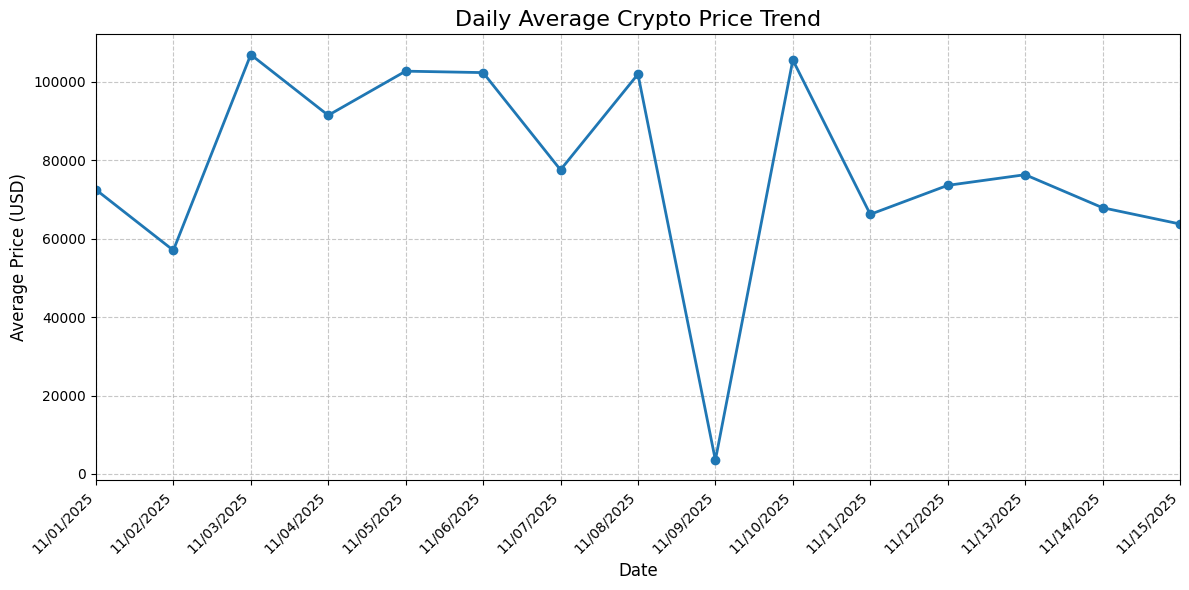

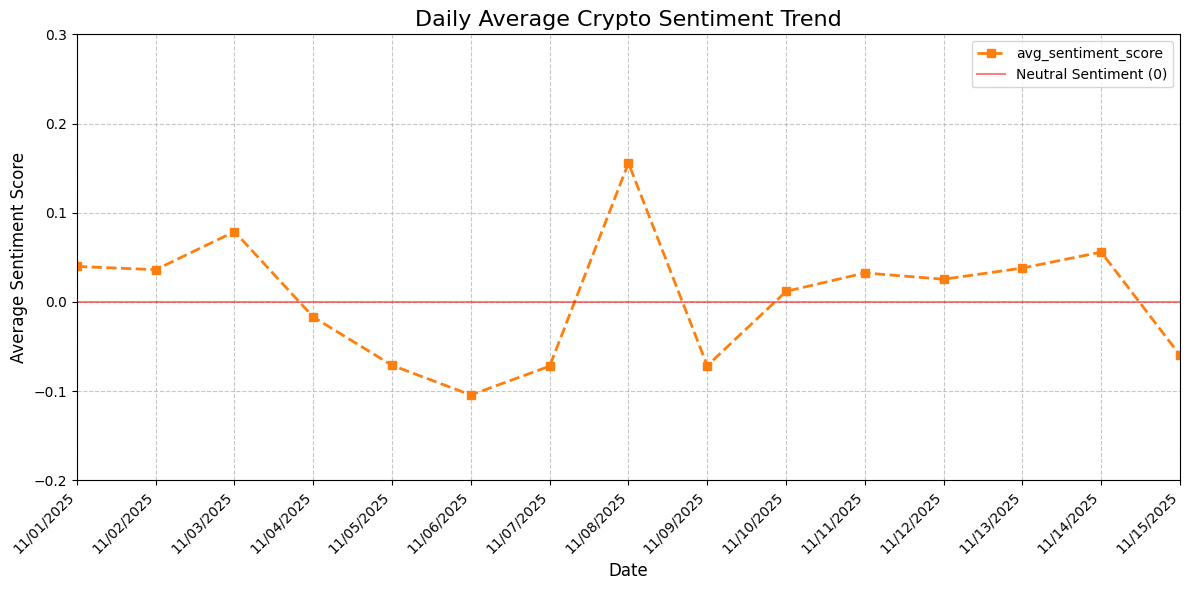

In [123]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd



# Set 'date' as the index for time-series plotting
df_daily_mean = df_daily_mean.set_index('date')

# ----------------------------------------------------------------------
# 1. Daily Average Price Trend Plot
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Plot the price trend
df_daily_mean['avg_price'].plot(
    kind='line',
    marker='o',
    color='tab:blue',
    linewidth=2
)

plt.title("Daily Average Crypto Price Trend", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format X-axis to show dates cleanly
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 2. Daily Average Sentiment Trend Plot
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Plot the sentiment trend
df_daily_mean['avg_sentiment_score'].plot(
    kind='line',
    marker='s',
    color='tab:orange',
    linestyle='--',
    linewidth=2
)

plt.axhline(y=0, color='r', linestyle='-', alpha=0.5, label='Neutral Sentiment (0)') # Add neutral line
plt.title("Daily Average Crypto Sentiment Trend", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.ylim(-0.2, 0.3) # Set a fixed Y-limit for better comparison
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format X-axis to show dates cleanly
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

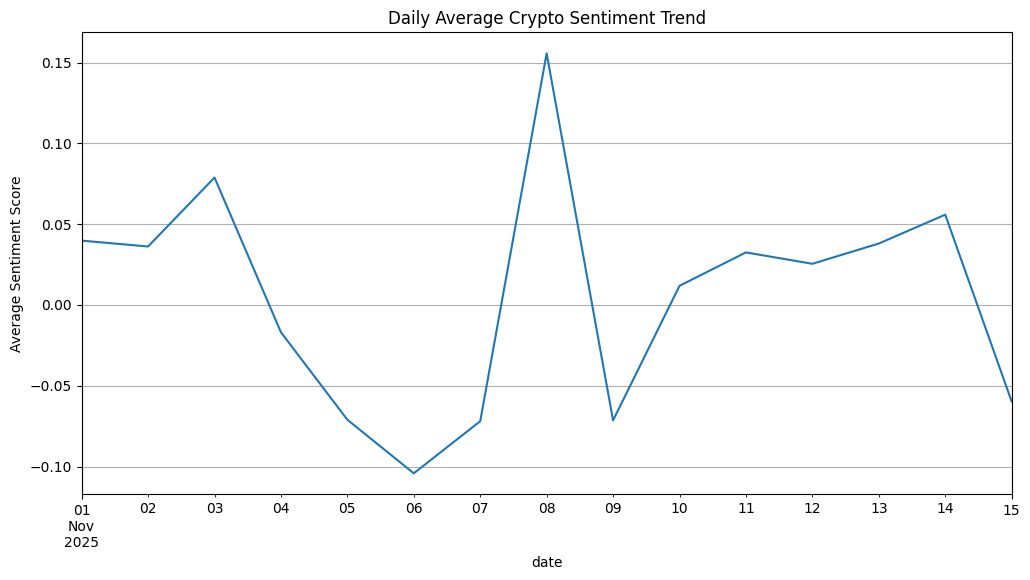

In [124]:
#time series analysis

import matplotlib.pyplot as plt

#convert pyspark dataframe to pandas dataframe
df_pandas = df_reddit_filtered.toPandas()

# 1. Overall Sentiment Trend
df_daily_sentiment = df_pandas.set_index('date').resample('D')['sentiment_score'].mean()

plt.figure(figsize=(12, 6))
df_daily_sentiment.plot(title="Daily Average Crypto Sentiment Trend")
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.show()

In [125]:
#correlation coefficient with mean

# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient = df_daily_mean['avg_price'].corr(df_daily_mean['avg_sentiment_score'])

print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.22432766426010067


In [128]:
# --- 1. PySpark Aggregation for BTC Only ---
TARGET_CRYPTO = 'BTC' # Targeting Bitcoin
# Filter for BTC, then group by date and aggregate
df_daily_mean_BTC_spark = df_reddit_filtered\
  .filter(F.col("cryptocurrency") == TARGET_CRYPTO)\
    .withColumn(
      'date',
        F.date_trunc('day', F.col('date')) # Truncate 4h interval timestamps to the day
        ).groupBy("date").agg(
            F.mean("sentiment_score").alias("avg_sentiment_score"),
            F.mean("price").alias("avg_price")
        ).orderBy("date") \
        .withColumn("cryptocurrency", F.lit(TARGET_CRYPTO)) # Add the currency column back

    # Convert the small aggregated result to a local Pandas DataFrame for plotting
df_daily_mean_BTC = df_daily_mean_BTC_spark.toPandas()




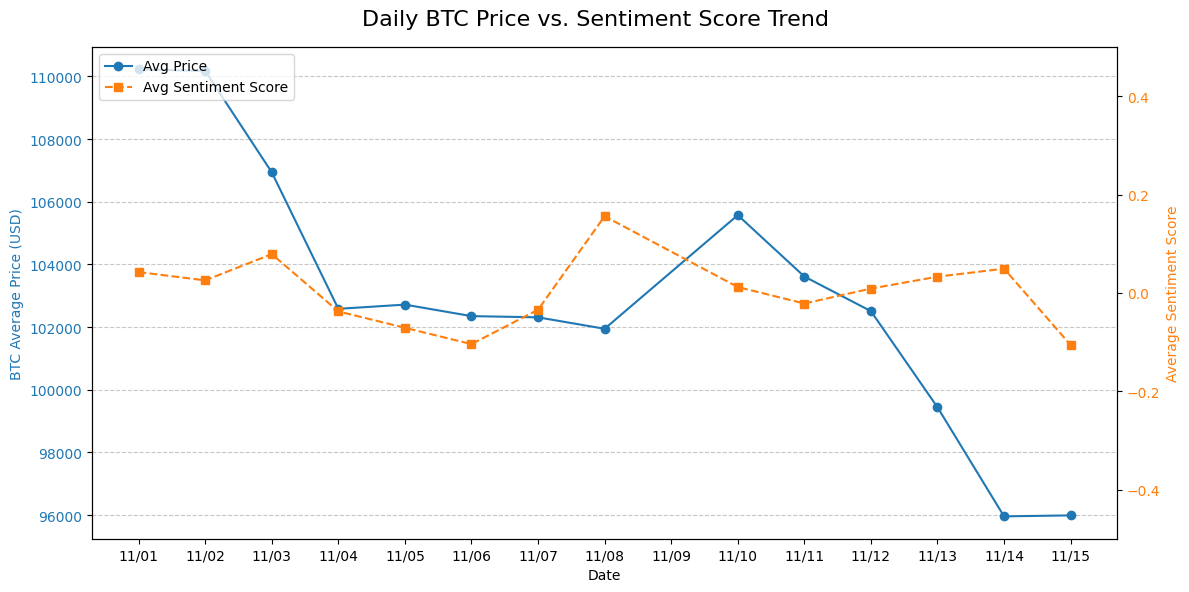

In [129]:
# --- 2. Pandas Plotting (Dual-Axis) ---
if not df_daily_mean_BTC.empty:
    df_daily_mean_BTC = df_daily_mean_BTC.set_index('date')

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot 1: Average Price (Primary Y-axis, left)
    color_price = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{TARGET_CRYPTO} Average Price (USD)', color=color_price)
    line1 = ax1.plot(df_daily_mean_BTC.index, df_daily_mean_BTC['avg_price'], color=color_price, marker='o', linestyle='-', label='Avg Price')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Average Sentiment Score (Secondary Y-axis, right)
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color_sentiment = 'tab:orange'
    ax2.set_ylabel('Average Sentiment Score', color=color_sentiment)
    line2 = ax2.plot(df_daily_mean_BTC.index, df_daily_mean_BTC['avg_sentiment_score'], color=color_sentiment, marker='s', linestyle='--', label='Avg Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color_sentiment)
    ax2.set_ylim(-0.5, 0.5) # Set a fixed y-limit for sentiment score for readability

    # Add a combined title and legend
    fig.suptitle(f'Daily {TARGET_CRYPTO} Price vs. Sentiment Score Trend', fontsize=16)

    # Combine legends from both axes
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Format X-axis for better date display
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xticks(rotation=45, ha='right')

    fig.tight_layout()
    plt.show()
else:
    print(f"❌ Cannot plot: DataFrame for {TARGET_CRYPTO} is empty after aggregation.")

In [131]:
#correlation coefficient with mean

# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient = df_daily_mean_BTC['avg_price'].corr(df_daily_mean_BTC['avg_sentiment_score'])

print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.26314262454394977


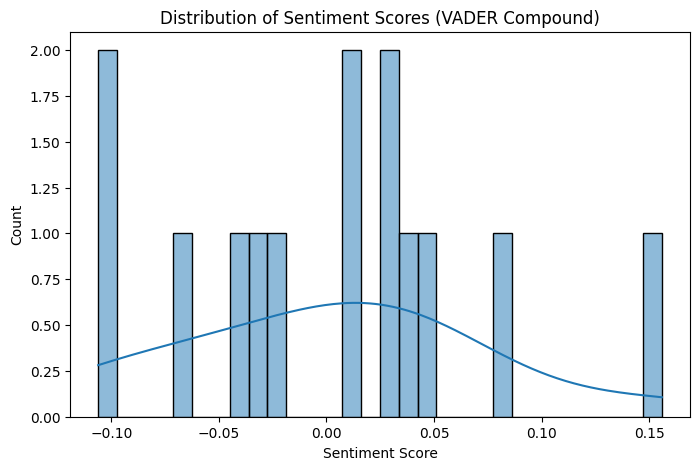

In [130]:
#distribution analysis: Visualize the distribution
#of the core metric, sentiment_score, to see if the overall mood is neutral, positive, or negative.

import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_daily_mean_BTC['avg_sentiment_score'], bins=30, kde=True)
plt.title("Distribution of Sentiment Scores (VADER Compound)")
plt.xlabel("Sentiment Score")
plt.show()

/tmp/ipython-input-3127082703.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'cryptocurrency', y='unique_user_count',data=df_pandas_count, palette='viridis')


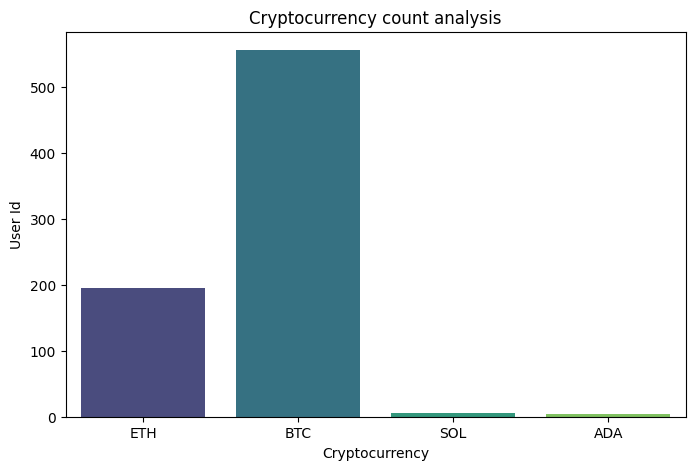

In [96]:

import seaborn as sns

from pyspark.sql import functions as F

# 1. Group by cryptocurrency and count the number of records (posts/comments).
#df_count_spark = df_filtered_and_joined.groupBy("cryptocurrency").count().orderBy(F.desc("count"))

from pyspark.sql.functions import col, countDistinct
df_count_spark =  df_reddit_filtered.groupBy("cryptocurrency").agg(countDistinct("user_id").alias("unique_user_count"))

# 2. Convert the small aggregated result to a Pandas DataFrame for plotting.
df_pandas_count = df_count_spark.toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x= 'cryptocurrency', y='unique_user_count',data=df_pandas_count, palette='viridis')
plt.title("Cryptocurrency count analysis")
plt.xlabel("Cryptocurrency")
plt.ylabel("User Id")
plt.show()

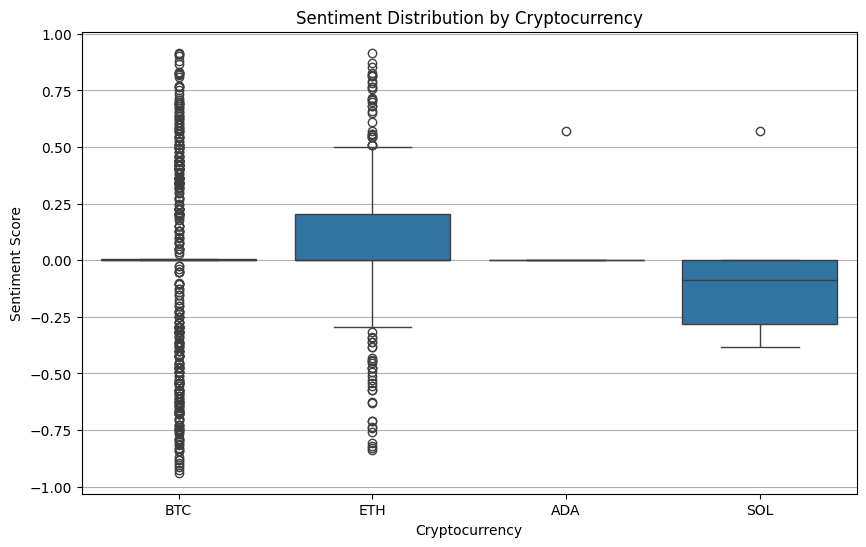


--- Mean Sentiment by Coin ---
cryptocurrency
ADA    0.114380
ETH    0.060676
BTC   -0.005731
SOL   -0.051000
Name: sentiment_score, dtype: float64


In [86]:
#Distribution analysis

plt.figure(figsize=(10, 6))
# Create a box plot to compare the sentiment distribution across different cryptocurrencies
sns.boxplot(x='cryptocurrency', y='sentiment_score', data=df_pandas)
plt.title("Sentiment Distribution by Cryptocurrency")
plt.xlabel("Cryptocurrency")
plt.ylabel("Sentiment Score")
plt.grid(axis='y')
plt.show()

# Calculate the mean sentiment for each coin
mean_sentiment_by_coin = df_pandas.groupby('cryptocurrency')['sentiment_score'].mean().sort_values(ascending=False)
print("\n--- Mean Sentiment by Coin ---")
print(mean_sentiment_by_coin)

In [ ]:
#remove rows which has a garbage timestamp or null timestamp --done

In [ ]:
#create a bar chart for cryptocurrency to demonstrate number of users who post and comment for cryptocurrency -- done

In [ ]:
#create a column chart for number of title and revviews for cryptocurrency

In [ ]:
#create a bar chart to count sentiment score for cryptocurrency -- donne

In [ ]:
#polarity score check

In [ ]:
#time series analysis -- timeestamp as id-- with pricing and sentiment data --done

In [ ]:
#Corelation coefficient --done

In [ ]:
#https://www.kaggle.com/code/suzanaiacob/sentiment-analysis-of-the-yelp-reviews-data
#https://www.kaggle.com/code/serkanp/imdb-sentiment-analysis-data-exploration
#https://www.kaggle.com/code/ryanholbrook/exercise-binary-classification
#https://www.kaggle.com/code?searchQuery=sentiment+data+
#https://www.kaggle.com/code/benhamner/exploring-airline-twitter-sentiment-data
#https://www.kaggle.com/code/seunowo/sentiment-analysis-twitter-dataset

In [ ]:
sc.stop()